# Term1 Sprint4 授業課題 
## コーディング課題：Logistic回帰スクラッチ

NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していく。

## 1. Logistic回帰のクラスを作成する
ロジスティック回帰のクラスを作成し、Sprint0で作成した分類のパイプラインに組み込む。  
クラスの基本構造はSprint3の線形回帰を参考にし、名前はScratchLogisticRegressionとする。  
メソッドやパラメータなどはscikit-learnを参考にする。  
推定関係ではラベルを出力するpredictメソッドと、確率を出力するpredict_probaメソッドの2種類を作成する。  
[sklearn.linear_model.LogisticRegression — scikit-learn 0.20.3 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html "sklearn.linear_model.LogisticRegression — scikit-learn 0.20.3 documentation")

検証段階ではJupyter Notebook上で書いていき、最終的にはpyファイルにモジュールとしてまとめる。

**シグモイド関数**
$$g(z)=\frac{1}{1+e^{-z}}$$


正しく動作しているかを確認するために、この関数に-10から10の値を入力したときの出力をプロットしておく。

**目的関数**  
以下の数式で表されるロジスティック回帰の目的関数$J$を実装する。この数式には正則化項が含まれている。
$$h_{\theta}(x)=g(\theta^Tx)$$
$$g(z)=\frac{1}{1+e^{-z}}$$
$$J(\theta)=\frac{1}{m}\sum_{i=1}^m[-y^{(i)}log(h_{\theta}(x^{(i)}))-(1-y^{(i)})log(1-h_{\theta}(x^{(i)}))]+\frac{\lambda}{2m}\sum_{j=1}^n\theta_j^2$$

$m$ : 入力されるデータの数  
$h_\theta()$ : 仮定関数  
$x$ : 特徴量ベクトル  
$\theta$ : パラメータベクトル  
$g()$ : シグモイド関数  
$x^{(i)}$ : i番目のサンプルの特徴量ベクトル  
$y^{(i)}$ : i番目のサンプルの正解ラベル  
$\theta_j$ : j番目のパラメータ（重み）  
$n$ : 特徴量の数  
$\lambda$ : 正則化パラメータ  

**最急降下法**  
最急降下法により学習させる。バイアス項およびj番目のパラメータの更新には以下の式を使う。  
$$\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)}  ,j = 0\\$$
$$\frac{\partial J(\theta)}{\partial \theta_j} = \biggl(\frac{1}{m}  \sum_{i=1}^{m}(h_θ(x^{(i)}) − y^{(i)})x_j^{(i)} \biggr) + \frac{λ}{m}\theta_j　 ,j\geq 1$$

$i$ : サンプルのインデックス  
$j$ : 特徴量のインデックス

## 2. 学習曲線のプロット
学習曲線をプロットする。

## 3. 指標値の算出
分類に関する指標値で精度を確認する。

## 4. 決定領域の可視化
2値分類のデータセットに対して決定領域を可視化する。

## コーディング
実装内容として以下をpipe_clf.pyに記述した。大別して、ScratchLogistic回帰関数を含むパイプラインである関数log_regのコード、ScratchLogistic回帰関数自体のコード、学習済の分類器から評価・可視化までを行うscoring_funcのコード、可視化するための決定領域を出力する関数decision_regionのコードの4つから構成されている。

In [131]:
# 以下をpipe_clf.pyに組込み済

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from IPython.display import display
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def log_reg(X_train, X_test, y_train, y_test, feature_names, target_names, val_size, test_size, lr=0.1, two_features=False):
    """
    最急降下法によるScratchLogistic回帰のパイプライン。
    入力データを標準化、学習、評価し、各種スコア値を算出する。
    決定領域をプロットする場合は、入力特徴量のうち2種類の全組合わせでそれぞれ学習・評価し、可視化する。

    Parameters
    ----------------
    X_train : ndarray, shape(n_samples, n_features)
        学習用データの特徴量
    X_test : ndarray, shape(n_samples, n_features)
        テスト用データの特徴量
    y_train : ndarray, shape(m_samples,)
        学習用データの正解値
    y_test : ndarray, shape(m_samples,)
        テスト用データの正解値
    feature_names : list of str
        使用する全特徴量名のリスト
    target_names= : list of str
        使用する目的変数（ラベル）名のリスト
    val_size : float
      訓練データのうちfittingに使用する検証用データの比率
    test_size : float
      元データからX_trainとX_testに分割した際のX_testの比率
    lr : float （初期値： 0.1）
      ScratchLogisticRegressionの学習率
    two_features : boolean （初期値： False）
      多次元特徴量で学習し、可視化しない場合：False
      多次元特徴量から2種類の全組合わせで学習し、それぞれで可視化する場合：True
    """
    # X_train, y_trainを更に訓練データと検証データに分割
    X, X_val, y, y_val = train_test_split(X_train, y_train, test_size=val_size, stratify=y_train, random_state=0)
    
    # XとX_valをスケーリング
    sc = StandardScaler()
    sc.fit(X)
    X = sc.transform(X)
    X_val = sc.transform(X_val)
    
    # X_trainとX_testをスケーリング
    sc = StandardScaler()
    sc.fit(X_train)
    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)
    
    # X, yでfitting（X_val, y_valも検証用として引数に入れる）
    # 学習、評価し、5種スコアの集計表と混同行列・決定領域の可視化をする関数scoring_funcを出力する
    model_names = []
    models = []
    test_idx=range(np.floor((1-test_size)*X_train.shape[0]).astype("int"), X_train.shape[0])
    
    # 例外処理(TrueでもFalseでもない場合)
    if not (two_features==True or two_features==False):
        raise ValueError("Set boolean value to 'two_features' parameter !")
        
    # 多次元特徴量から2種類の全組み合わせのそれぞれで学習・評価し、それぞれで決定領域を可視化する場合
    if two_features==True or X.shape[1]==2:
        # 2種特徴量の組み合わせの列indexのタプルのリストを生成
        combs = list(itertools.combinations(np.arange(X.shape[1]), 2))
        for i, comb in enumerate(combs):
            print("------Taken features: {}, {}------".format(feature_names[comb[0]], feature_names[comb[1]]))
            clf = ScratchLogisticRegression(lr=lr)
            clf.fit(X[:, comb], y, X_val[:, comb], y_val)
            model_names.append("Scratch Logistic Regression")
            models.append(clf)
        # 別途定義のスコアリング関数にパラメータ移譲
        scoring_func(X_train, X_test, y_train, y_test, 
                 model_names, models, feature_names, target_names, test_idx, two_features)
        
    # 多次元特徴量で学習・評価し、決定領域は可視化しない（できない）場合
    else:
        clf = ScratchLogisticRegression(lr=lr)
        clf.fit(X, y, X_val, y_val)
        model_names.append("Scratch Logistic Regression")
        models.append(clf)
        # 別途定義のスコアリング関数にパラメータ移譲
        scoring_func(X_train, X_test, y_train, y_test, 
                 model_names, models, feature_names, target_names, test_idx)


class ScratchLogisticRegression:
    """
    最急降下法によるLogistic回帰のスクラッチ実装

    Parameters
    ----------
    n_iter : int （初期値： 50）
      イテレーション数
    lr : float （初期値： 0.1）
      学習率
    bias : bool （初期値： True）
      バイアス項を入れる場合はTrue
    verbose : bool （初期値： True）
      学習過程を出力する場合はTrue
    lam : float （初期値： 0.1）
      正則化項パラメータの変数ラムダ
    tol : float （初期値： 1e-3）
      毎回の学習によるコスト関数値の変化をストップするための閾値
    random_state : int （初期値： 1）
      重みを初期化するための乱数シード

    Attributes
    ----------
    self.w_ : 次の形のndarray, shape (n_features,)
      重みパラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      学習用データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証用データに対する損失の記録
    """
    
    def __init__(self, n_iter=50, lr=0.1, bias=True, verbose=True, lam=0.1, tol=1e-3, random_state=1):
        self.n_iter = n_iter
        self.lr = lr
        self.bias = bias
        self.verbose = verbose
        self.lam = lam
        self.tol = tol
        self.random_state = random_state
        # w_をまずNoneに設定
        self.w_ = None
        # コスト関数値を格納するリストを用意（便宜上、初期値はリストに入れておく）
        self.loss = [1, ]
        self.val_loss = [1, ]
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        Logistic回帰を学習する。損失もイテレーション毎に記録する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        rgen = np.random.RandomState(self.random_state)
        diff = np.inf
        iteration = 0
        
        # バイアス項なしの場合
        if self.bias == False:
            # w_をランダムに初期化
            self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
            # コスト関数値の変化が変数tol以下または更新回数が変数n_iter以上となったらストップ
            while diff > self.tol and iteration < self.n_iter:
                w_prev = self.w_
                # yの推測値をXとX_valで計算
                y_pred = self.sigmoid(np.dot(X, self.w_))
                if X_val is not None and y_val is not None:
                    y_val_pred = self.sigmoid(np.dot(X_val, self.w_))
                else:
                    y_val_pred = None
                # コスト関数値の計算、リスト格納、変化の値の更新
                self._cost_func(X, y, y_pred, X_val, y_val, y_val_pred)
                # 学習率 * 勾配を計算し、パラメータ更新
                self.w_ -= self.lr * (np.dot(X.T, (y_pred - y)) / X.shape[0] + (self.lam / X.shape[0]) * self.w_)
                iteration += 1
        
        # バイアス項ありの場合
        elif self.bias == True:
            # w_をランダムに初期化
            self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1+X.shape[1])
            # X, X_valにx_0=1の列を追加
            X = np.hstack([np.ones(X.shape[0]).reshape(-1,1), X])
            if X_val is not None:
                X_val = np.hstack([np.ones(X_val.shape[0]).reshape(-1,1), X_val])
            # コスト関数値の変化が変数tol以下または更新回数が変数n_iter以上となったらストップ
            while diff > self.tol and iteration < self.n_iter:
                w_prev = self.w_
                # yの推測値をXとX_valで計算
                y_pred = self.sigmoid(np.dot(X, self.w_))
                if X_val is not None and y_val is not None:
                    y_val_pred = self.sigmoid(np.dot(X_val, self.w_))
                else:
                    y_val_pred = None
                # コスト関数値の計算、リスト格納、変化の値の更新
                self._cost_func(X, y, y_pred, X_val, y_val, y_val_pred)
                 # 学習率 * 勾配を計算し、パラメータ更新
                self.w_[0] -= self.lr * (np.dot(X[:, 0], (y_pred - y)) / X.shape[0])
                self.w_[1:] -= self.lr * (np.dot(X[:, 1:].T, (y_pred - y)) / X.shape[0] + (self.lam / X.shape[0]) * self.w_[1:])
                iteration += 1
        
        # バイアス項エラーの場合
        else:
            raise ValueError("Set boolean value to 'bias' parameter !")
        
        # 学習過程をプロットする場合
        if self.verbose:
            self._cost_plot_func(self.loss, self.val_loss)
    
    def predict(self, X_test):
        """
        fittingした回帰器を使い、ラベル推定結果を返す。

        Parameters
        ----------
        X_test : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            Logistic回帰によるラベル推定結果
        """
        if self.bias == True:
            X_test = np.hstack([np.ones(X_test.shape[0]).reshape(-1,1), X_test])
        y_pred = self.sigmoid(np.dot(X_test, self.w_))
        return np.where(y_pred > 0.5, 1, 0)
    
    def predict_proba(self, X_test):
        """
        fittingした回帰器を使い、ラベル推定の確率を返す。

        Parameters
        ----------
        X_test : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量

        Returns
        -------
            次の形のndarray, shape (n_samples, n_classes)
            Logistic回帰によるラベル推定確率
        """
        if self.bias == True:
            X_test = np.hstack([np.ones(X_test.shape[0]).reshape(-1,1), X_test])
        y_pred = self.sigmoid(np.dot(X_test, self.w_)).reshape(-1,1)
        return np.hstack((1 - y_pred, y_pred))
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def _cost_func(self, X, y, y_pred, X_val=None, y_val=None, y_val_pred=None):
        # コスト関数値を計算し、リストに格納
        cost = (-np.dot(y, np.log(y_pred)) - np.dot(
            1 - y, np.log(1 - y_pred)))/X.shape[0] + self.lam / (2.0 * X.shape[0]) * np.sum(self.w_**2)
        self.loss.append(cost)
        # 検証用データがあれば同様に処理
        if X_val is not None and y_val is not None and y_val_pred is not None:
            val_cost = (-np.dot(y_val, np.log(y_val_pred)) - np.dot(
                1 - y_val, np.log(1 - y_val_pred)))/X_val.shape[0] + self.lam / (2.0 * X_val.shape[0]) * np.sum(self.w_**2)
            self.val_loss.append(val_cost)
        # コスト関数値の変化の値を更新
        diff = self.loss[-2] - self.loss[-1]
    
    def _cost_plot_func(self, loss, val_loss):
        print("------コスト関数値の推移（学習用データ）------\n", loss)
        plt.plot(np.arange(len(loss)), loss, color="steelblue", linestyle="-", label="Train")
        if len(val_loss) > 1:
            print("------コスト関数値の推移（検証用データ）------\n", val_loss)
            plt.plot(np.arange(len(val_loss)), val_loss, color="orangered", linestyle="--", label="Validation")
        plt.xlabel("n_iter")
        plt.ylabel("cost func with L2")
        plt.title("Learning curve")
        plt.legend(loc="best")
        plt.show()


def scoring_func(X_train, X_test, y_train, y_test, 
                 model_names, models, feature_names, target_names, test_idx, two_features=False):
    """
    多値分類（3種まで）を多次元特徴量において複数の学習済モデルで予測・評価し、以下1.、2.、3.を出力する。
    
    2次元特徴量データを評価・可視化する場合、
    または多次元特徴量データから2種類取り出す全組合せにてそれぞれ評価・可視化する場合は、
    4.も追加で出力する。
    
    1. 訓練データの正解率、テストデータの正解率、適合率、再現率、f1スコアの5種の集計表
    2. 1.の集計表の棒グラフ
    3. 混同行列をモデル別に行ごとにまとめた図
    4. 決定領域をモデル別に行ごとにまとめた図
    
    決定領域の出力には別途作成したdecision_region関数を利用する。

    Parameters
    ----------------
    X_train : ndarray, shape(n_samples, n_features)
        学習用データの特徴量
    X_test : ndarray, shape(n_samples, n_features)
        テスト用データの特徴量
    y_train : ndarray, shape(m_samples,)
        学習用データの正解値
    y_test : ndarray, shape(m_samples,)
        テスト用データの正解値
    model_names : list of str
        グラフタイトルに組み込むmodel名のリスト
    models : list of instances
        学習するモデルのインスンタスのリスト
    feature_names : list of str
        入力する特徴量名のリスト
    target_names= : list of str
        目的ラベル名のリスト
    test_idx : range of int
        テストデータのindex
    two_features : boolean （初期値：False）
        多次元特徴量から2種類の特徴量を取り出す全組合せでそれぞれ評価、可視化する場合はTrueに設定
    """
    score = []
    scoring_names = ["train_accuracy", "test_accuracy", "test_precision", "test_recall", "test_f1_score"]
    # 予測後、評価リストを作成し、model毎に混同行列と決定境界を可視化
    for i, model_name, model in zip(np.arange(len(models)), model_names, models):
        # 予測
        if two_features==True:
            combs = list(itertools.combinations(np.arange(X_train.shape[1]), 2))
            y_train_pred = model.predict(X_train[:, combs[i]])
            y_test_pred = model.predict(X_test[:, combs[i]])
        elif two_features==False:
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
        # 例外処理(TrueでもFalseでもない場合)
        else:
            raise ValueError("Set boolean value to 'two_features' parameter !")
            
        # 評価
        score.append(accuracy_score(y_train, y_train_pred)) # 訓練データの正解率を算出
        score.append(accuracy_score(y_test, y_test_pred)) # テストデータの正解率を算出
        score.append(precision_score(y_test, y_test_pred)) # テストデータの適合率を算出
        score.append(recall_score(y_test, y_test_pred)) # テストデータの再現率を算出
        score.append(f1_score(y_test, y_test_pred)) # テストデータのf1スコアを算出
        # 混同行列を可視化
        plt.rcParams["font.size"] = 16
        plt.figure(figsize=(20,5))
        plt.subplot(1,2,1)
        conf_mat = confusion_matrix(y_test, y_test_pred)
        sns.heatmap(conf_mat, annot=True)
        plt.title(model_name)
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        # 2次元特徴量であれば決定境界を可視化
        if X_train.shape[1]==2 or two_features==True:
            plt.subplot(1,2,2)
            if X_train.shape[1]==2:
                X_combined = np.vstack((X_train, X_test))
                y_combined = np.hstack((y_train, y_test))
                # 別途定義の決定領域出力関数にパラメータ移譲
                decision_region(X=X_combined, y=y_combined, model=model, step=0.01, test_idx=test_idx, 
                                feature_names=feature_names, 
                                target_names=target_names, model_name=model_name)
                plt.show()
            else:
                X_combined = np.vstack((X_train[:, combs[i]], X_test[:, combs[i]]))
                y_combined = np.hstack((y_train, y_test))
                # 別途定義の決定領域出力関数にパラメータ移譲
                decision_region(X=X_combined, y=y_combined, model=model, step=0.01, test_idx=test_idx, 
                                feature_names=[feature_names[combs[i][0]], feature_names[combs[i][1]]], 
                                target_names=target_names, model_name=model_name)
                plt.show()
    # 評価したスコアを集計して表示
    score = np.array(score).reshape(-1,5).round(2) # 各列を5種のスコアに変形
    score = pd.DataFrame(score, index=model_names, columns=scoring_names)
    display(score) # スコアのDataFrameを表示
    score.T.plot(kind="bar") # スコア毎に棒グラフを表示
    plt.legend(bbox_to_anchor=(1,1))
    plt.ylim(0.6,1.05)
    plt.show()


def decision_region(X, y, model, step=0.01, test_idx=None, feature_names=None, target_names=None, model_name=None):
    """
    多値分類（3種まで）を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は学習用・テスト用データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        学習用・テスト用データの特徴量
    y : ndarray, shape(n_samples,)
        学習用・テスト用データの正解値
    model : object
        学習したモデルのインスンタス
    step : float, (default : 0.01)
        推定値を計算する間隔
    test_idx : range of int
        テストデータのindex
    feature_names : list of str
        軸ラベルの一覧
    target_names= : list of str
        凡例の一覧
    model_name : str
        グラフタイトルに組み込むmodel名
    """
    # setting（2値分類の場合は2色、3値分類の場合は3色としておく）
    n_class = np.unique(y).shape[0]
    scatter_color = ['red', 'blue', 'green']
    contourf_color = ['pink', 'skyblue', 'lightgreen']
    if n_class<3:
        scatter_color = ['red', 'blue']
        contourf_color = ['pink', 'skyblue']    

    # pred
    x1_min, x1_max = np.min(X[:, 0])-0.5, np.max(X[:, 0])+0.5
    x2_min, x2_max = np.min(X[:, 1])-0.5, np.max(X[:, 1])+0.5
    xx1, xx2  = np.meshgrid(np.arange(x1_min, x1_max, step), np.arange(x2_min, x2_max, step))
    mesh = np.c_[np.ravel(xx1), np.ravel(xx2)]
    Z = model.predict(mesh).reshape(xx1.shape)

    # train & test plot
    plt.contourf(xx1, xx2, Z, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(xx1, xx2, Z, n_class-1, colors='black', linewidths=2, alpha=0.5)
    for i, target in enumerate(np.unique(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], 
                    s=80, color=scatter_color[i], alpha=0.3, label=target_names[i], marker='o')
    plt.title("decision region["+model_name+"]")
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    
    # emphasizing test plot only
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        for i, target in enumerate(np.unique(y_test)):
            plt.scatter(X_test[y_test==target][:, 0], X_test[y_test==target][:, 1], 
                        s=100, color=scatter_color[i], edgecolor="black", alpha=1.0, linewidth=1, 
                        label=target_names[i]+"[test_set]", marker="o")
    plt.legend(loc="best")


以上のコードを以下で実際に実行してみる。2-4種類の特徴量とtwo_featuresパラメータの有無の組合せの計6通りで試す。
1. 特徴量2種類、two_features=Falseの場合
2. 特徴量3種類、two_features=Falseの場合
3. 特徴量4種類、two_features=Falseの場合
4. 特徴量2種類、two_features=Trueの場合
5. 特徴量3種類、two_features=Trueの場合
6. 特徴量4種類、two_features=Trueの場合

In [275]:
# 実際にpy.ファイルを呼び出して実行する
import sys
sys.path.append("../ml-scratch/models/")
import pipe_clf
from importlib import reload
reload(pipe_clf)

<module 'pipe_clf' from '../ml-scratch/models/pipe_clf.py'>

### 1. 特徴量2種類、two_features=Falseの場合

------Taken features: sepal_length(cm)[standardized], sepal_width(cm)[standardized]------
------コスト関数値の推移（学習用データ）------
 [1, 0.6935883863399754, 0.5993150322021538, 0.5262234023024598, 0.468920192748845, 0.4232922188647951, 0.3863474034833534, 0.35594339001548725, 0.33054414313856956, 0.3090372069439069, 0.2906055207182159, 0.27463965524139816, 0.2606779527175545, 0.24836544489696097, 0.23742534437470056, 0.22763899610407198, 0.21883157846407125, 0.2108617602200693, 0.2036141157816334, 0.19699348991395876, 0.19092075869366354, 0.18532960341040342, 0.1801640284039608, 0.17537643165862524, 0.17092609064308154, 0.16677796334068387, 0.16290173086790688, 0.15927102697330692, 0.1558628133520601, 0.15265686966401437, 0.14963537447579073, 0.14678255880024238, 0.1440844179975179, 0.14152847089710316, 0.1391035573607111, 0.13679966731980886, 0.13460779572557166, 0.13251981894323356, 0.1305283889811169, 0.12862684262211108, 0.12680912306329867, 0.1250697120989692, 0.12340357122710523, 0.121806090

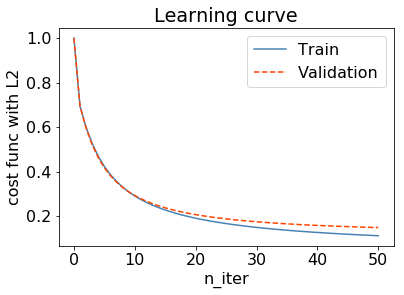

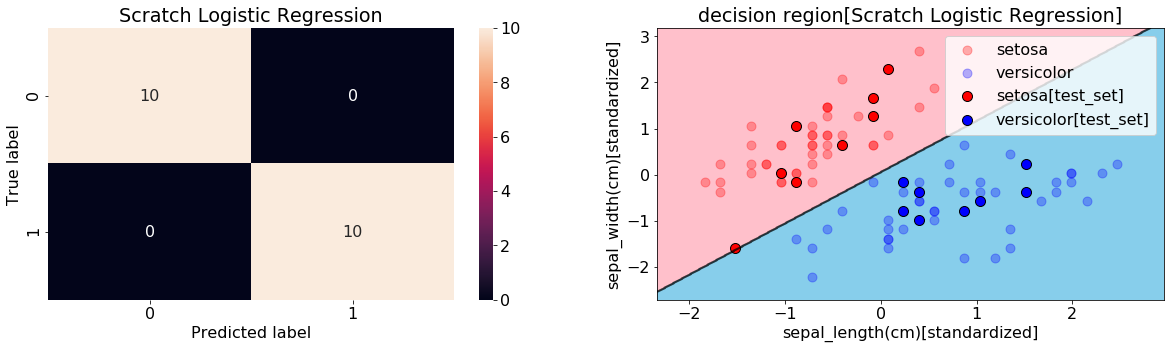

,train_accuracy,test_accuracy,test_precision,test_recall,test_f1_score
Scratch Logistic Regression,1.0,1.0,1.0,1.0,1.0


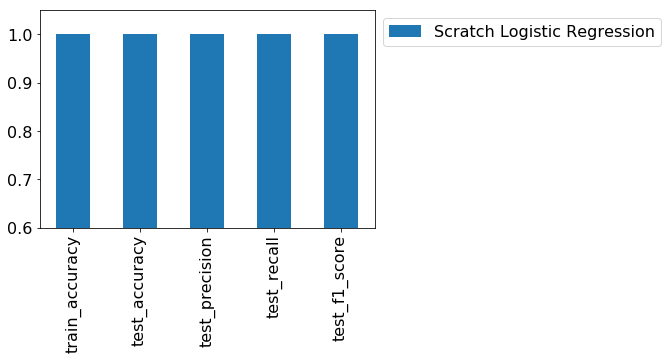

In [282]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# irisの2値分類(SetosaとVersicolor)
iris = load_iris()
X = iris.data[:100, :2]
y = iris.target[:100]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=0)
feature_names=["sepal_length(cm)[standardized]", "sepal_width(cm)[standardized]"]
target_names=['setosa', 'versicolor']

pipe_clf.log_reg(X_train, X_test, y_train, y_test, 
                 feature_names, target_names, lr=0.4, val_size=0.20, test_size=0.20, two_features=False)

### 2. 特徴量3種類、two_features=Falseの場合

------コスト関数値の推移（学習用データ）------
 [1, 0.6987755995349332, 0.5240165924023027, 0.4138958476453865, 0.3410703857416227, 0.29021605789283705, 0.25297589607226495, 0.22462575589947123, 0.20235646693575926, 0.184413090933005, 0.16965013541364177, 0.15729102731857939, 0.1467918832348704, 0.13776097083746716, 0.1299092281033706, 0.12301880893234882, 0.11692247532124363, 0.11148972979837932, 0.10661725888279959, 0.10222220595265881, 0.09823734467208203, 0.09460755601785217, 0.09128721652148714, 0.0882382344858972, 0.08542855425572439, 0.08283100345674842, 0.08042239487438847, 0.0781828196934099, 0.07609508616277197, 0.07414426992708639, 0.07231735093144902, 0.07060291804893429, 0.06899092712912153, 0.0674725015167765, 0.06603976658278059, 0.06468571168169819, 0.06340407436900182, 0.06218924279482892, 0.061036173025742366, 0.05994031869339688, 0.058897570874777955, 0.05790420650640121, 0.056956843949589255, 0.056052404574488256, 0.05518807943107029, 0.054361300236823076, 0.05356971404145776, 0.052

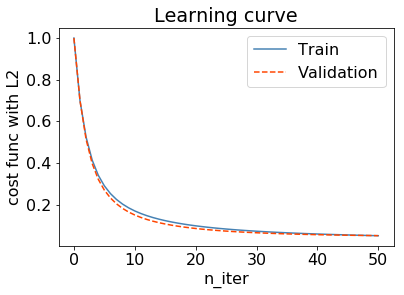

,train_accuracy,test_accuracy,test_precision,test_recall,test_f1_score
Scratch Logistic Regression,1.0,1.0,1.0,1.0,1.0


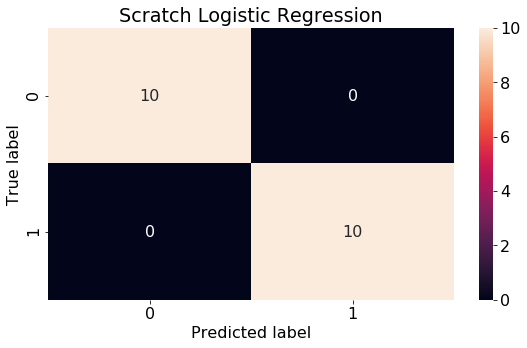

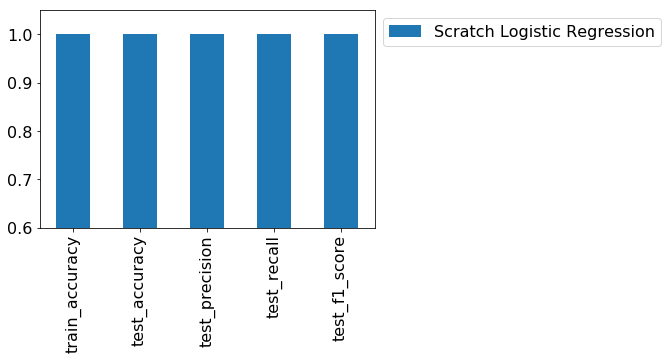

In [283]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# irisの2値分類(SetosaとVersicolor)
iris = load_iris()
X = iris.data[:100, :3]
y = iris.target[:100]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=0)
feature_names=["sepal_length(cm)[standardized]", "sepal_width(cm)[standardized]", 
               "petal_length(cm)[standardized]"]
target_names=['setosa', 'versicolor']

pipe_clf.log_reg(X_train, X_test, y_train, y_test, 
                 feature_names, target_names, lr=0.4, val_size=0.20, test_size=0.20, two_features=False)

### 3. 特徴量4種類、two_features=Falseの場合

------コスト関数値の推移（学習用データ）------
 [1, 0.6945851483821595, 0.450788109108105, 0.32720380122520115, 0.25644420535466755, 0.21130818536939003, 0.18016126082298478, 0.15740706775844843, 0.14006269887197023, 0.12640331935296564, 0.11536531398014682, 0.10625815911472672, 0.09861435999452849, 0.09210624240609509, 0.08649734317158993, 0.0816127366152155, 0.07732022880842178, 0.07351804835677986, 0.07012656008566377, 0.06708254778887164, 0.06433518272115556, 0.06184312516500053, 0.05957240413246967, 0.05749484185912053, 0.055586866423537405, 0.0538286052841053, 0.05220318508789824, 0.05069618495090091, 0.049295205315357235, 0.047989524823254505, 0.046769824912282876, 0.04562796702049339, 0.04455681102394585, 0.04355006626046447, 0.04260216850619248, 0.04170817777240083, 0.04086369291911475, 0.04006477993912457, 0.039307911421830107, 0.03858991521225596, 0.0379079306736535, 0.03725937126965895, 0.036641892424203126, 0.036053363809336644, 0.03549184536417428, 0.03495556647085786, 0.03444290781233142

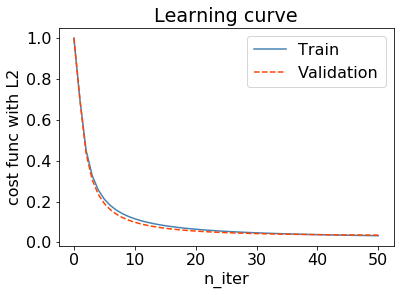

,train_accuracy,test_accuracy,test_precision,test_recall,test_f1_score
Scratch Logistic Regression,1.0,1.0,1.0,1.0,1.0


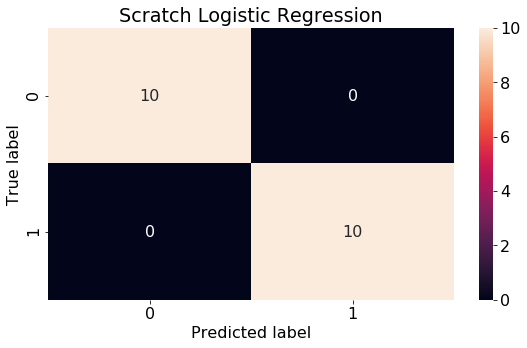

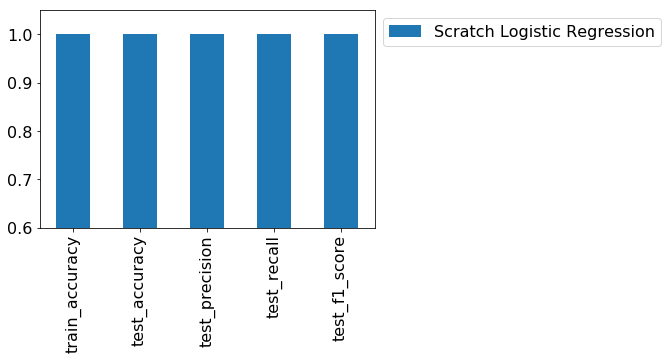

In [284]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# irisの2値分類(SetosaとVersicolor)
iris = load_iris()
X = iris.data[:100, :]
y = iris.target[:100]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=0)
feature_names=["sepal_length(cm)[standardized]", "sepal_width(cm)[standardized]", 
                   "petal_length(cm)[standardized]", "pepal_width(cm)[standardized]"]
target_names=['setosa', 'versicolor']

pipe_clf.log_reg(X_train, X_test, y_train, y_test, 
                 feature_names, target_names, lr=0.4, val_size=0.20, test_size=0.20, two_features=False)

### 4. 特徴量2種類、two_features=Trueの場合

------Taken features: sepal_length(cm)[standardized], sepal_width(cm)[standardized]------
------コスト関数値の推移（学習用データ）------
 [1, 0.6935883863399754, 0.5993150322021538, 0.5262234023024598, 0.468920192748845, 0.4232922188647951, 0.3863474034833534, 0.35594339001548725, 0.33054414313856956, 0.3090372069439069, 0.2906055207182159, 0.27463965524139816, 0.2606779527175545, 0.24836544489696097, 0.23742534437470056, 0.22763899610407198, 0.21883157846407125, 0.2108617602200693, 0.2036141157816334, 0.19699348991395876, 0.19092075869366354, 0.18532960341040342, 0.1801640284039608, 0.17537643165862524, 0.17092609064308154, 0.16677796334068387, 0.16290173086790688, 0.15927102697330692, 0.1558628133520601, 0.15265686966401437, 0.14963537447579073, 0.14678255880024238, 0.1440844179975179, 0.14152847089710316, 0.1391035573607111, 0.13679966731980886, 0.13460779572557166, 0.13251981894323356, 0.1305283889811169, 0.12862684262211108, 0.12680912306329867, 0.1250697120989692, 0.12340357122710523, 0.121806090

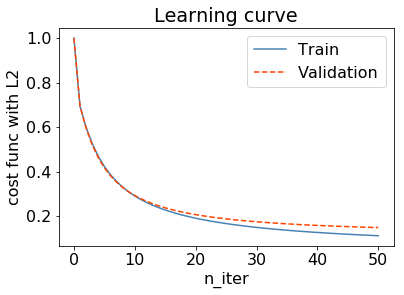

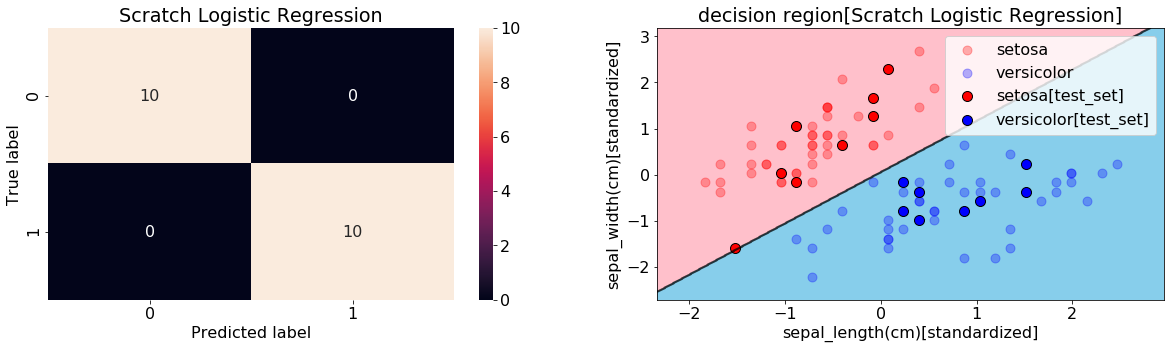

,train_accuracy,test_accuracy,test_precision,test_recall,test_f1_score
Scratch Logistic Regression,1.0,1.0,1.0,1.0,1.0


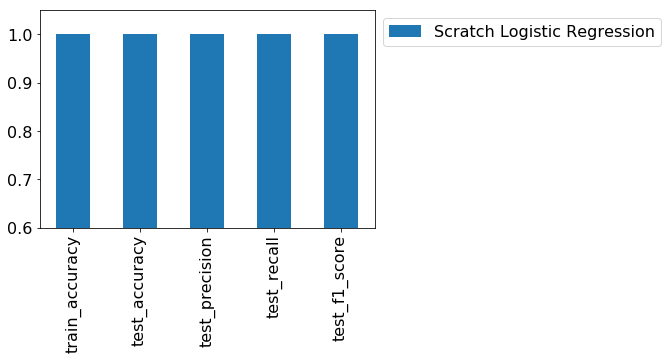

In [285]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# irisの2値分類(SetosaとVersicolor)
iris = load_iris()
X = iris.data[:100, :2]
y = iris.target[:100]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=0)
feature_names=["sepal_length(cm)[standardized]", "sepal_width(cm)[standardized]"]
target_names=['setosa', 'versicolor']

pipe_clf.log_reg(X_train, X_test, y_train, y_test, 
                 feature_names, target_names, lr=0.4, val_size=0.20, test_size=0.20, two_features=True)

### 5. 特徴量3種類、two_features=Trueの場合

------Taken features: sepal_length(cm)[standardized], sepal_width(cm)[standardized]------
------コスト関数値の推移（学習用データ）------
 [1, 0.6935883863399754, 0.5993150322021538, 0.5262234023024598, 0.468920192748845, 0.4232922188647951, 0.3863474034833534, 0.35594339001548725, 0.33054414313856956, 0.3090372069439069, 0.2906055207182159, 0.27463965524139816, 0.2606779527175545, 0.24836544489696097, 0.23742534437470056, 0.22763899610407198, 0.21883157846407125, 0.2108617602200693, 0.2036141157816334, 0.19699348991395876, 0.19092075869366354, 0.18532960341040342, 0.1801640284039608, 0.17537643165862524, 0.17092609064308154, 0.16677796334068387, 0.16290173086790688, 0.15927102697330692, 0.1558628133520601, 0.15265686966401437, 0.14963537447579073, 0.14678255880024238, 0.1440844179975179, 0.14152847089710316, 0.1391035573607111, 0.13679966731980886, 0.13460779572557166, 0.13251981894323356, 0.1305283889811169, 0.12862684262211108, 0.12680912306329867, 0.1250697120989692, 0.12340357122710523, 0.121806090

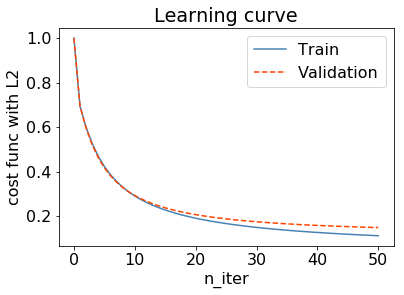

------Taken features: sepal_length(cm)[standardized], petal_length(cm)[standardized]------
------コスト関数値の推移（学習用データ）------
 [1, 0.6979605375197383, 0.56386415444074, 0.47265421089095466, 0.40846293543060747, 0.3614320363844233, 0.3256715445949838, 0.29760583679437447, 0.27498940675728756, 0.2563588171772087, 0.24072631122763233, 0.22740385455242312, 0.2158986618640279, 0.20584904952514613, 0.19698378411868636, 0.18909556447901213, 0.18202326409214614, 0.1756397554600079, 0.16984338197980794, 0.16455186856572762, 0.15969789718808108, 0.15522584083872112, 0.151089317605395, 0.14724933462243245, 0.14367286251522415, 0.14033172825164048, 0.13720174642087693, 0.13426203109845525, 0.1314944459423312, 0.12888316114416318, 0.12641429374122562, 0.12407561351840536, 0.12185630093223863, 0.11974674660601396, 0.11773838427912901, 0.11582355085755593, 0.113995368556184, 0.11224764515607275, 0.1105747891985168, 0.10897173756049494, 0.10743389334468724, 0.10595707240312442, 0.10453745712013715, 0.10317

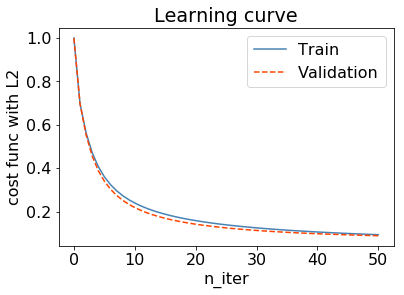

------Taken features: sepal_width(cm)[standardized], petal_length(cm)[standardized]------
------コスト関数値の推移（学習用データ）------
 [1, 0.6936195354494152, 0.5644183880520174, 0.47204372225580005, 0.40441064304247604, 0.3534287422725923, 0.31390270792080205, 0.282484237828588, 0.25696821929167224, 0.2358624779435711, 0.21812922199677576, 0.20302789971625831, 0.19001758432066398, 0.17869479786171688, 0.1687528983367938, 0.15995490753717875, 0.15211492107974353, 0.14508512611829683, 0.13874656315465483, 0.1330024382531218, 0.12777320494315259, 0.1229928951674217, 0.11860634573782018, 0.11456707617676701, 0.11083564673548996, 0.10737837477564276, 0.10416632167827014, 0.10117448615235997, 0.09838115657937087, 0.09576738703225075, 0.09331657030065472, 0.0910140876194363, 0.08884701950615503, 0.08680390563002251, 0.08487454428493409, 0.08304982405350908, 0.08132158179230956, 0.07968248225975463, 0.07812591563454799, 0.07664590989755828, 0.07523705562139447, 0.07389444116479067, 0.07261359662999947, 0.0

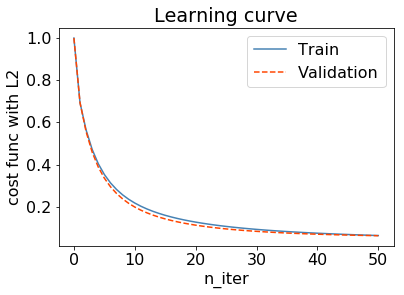

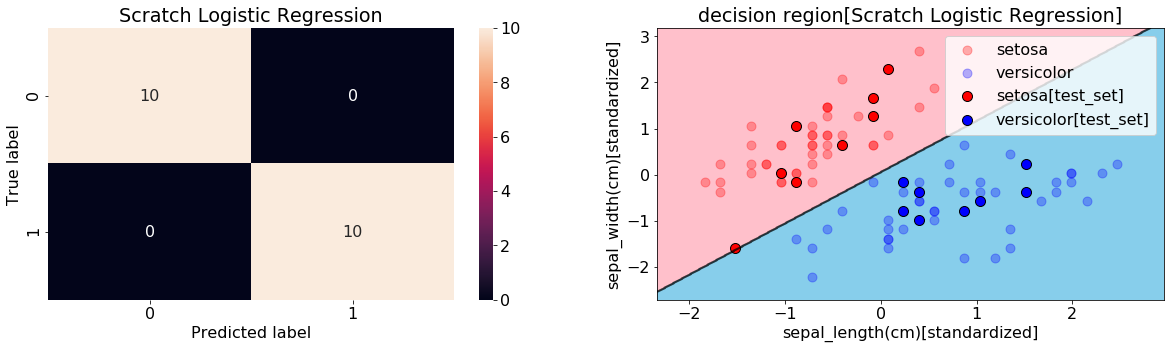

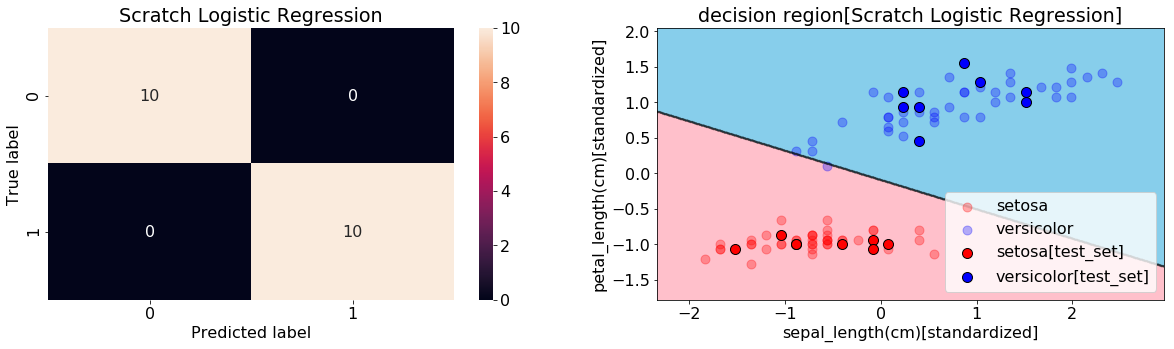

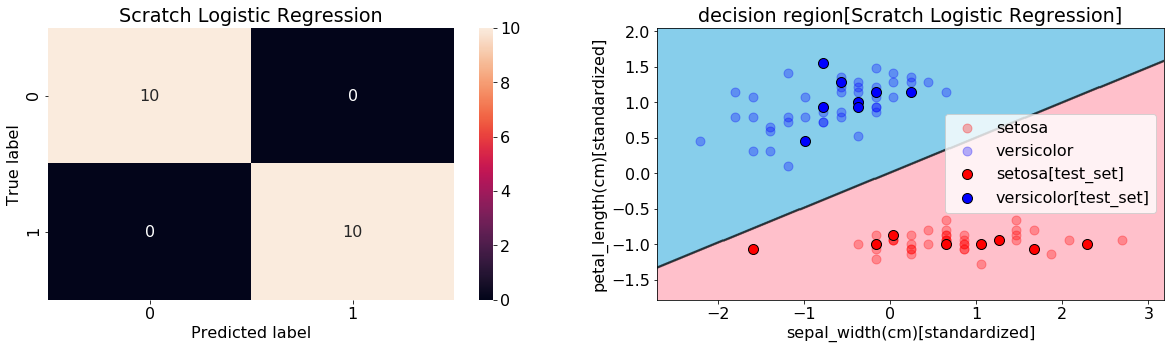

,train_accuracy,test_accuracy,test_precision,test_recall,test_f1_score
Scratch Logistic Regression,1.00,1.0,1.0,1.0,1.0
Scratch Logistic Regression,0.99,1.0,1.0,1.0,1.0
Scratch Logistic Regression,1.00,1.0,1.0,1.0,1.0


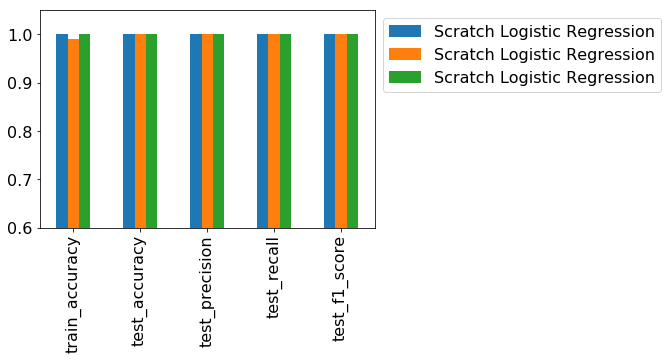

In [286]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# irisの2値分類(SetosaとVersicolor)
iris = load_iris()
X = iris.data[:100, :3]
y = iris.target[:100]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=0)
feature_names=["sepal_length(cm)[standardized]", "sepal_width(cm)[standardized]", 
                   "petal_length(cm)[standardized]"]
target_names=['setosa', 'versicolor']

pipe_clf.log_reg(X_train, X_test, y_train, y_test, 
                 feature_names, target_names, lr=0.4, val_size=0.20, test_size=0.20, two_features=True)

### 6. 特徴量4種類、two_features=Trueの場合

------Taken features: sepal_length(cm)[standardized], sepal_width(cm)[standardized]------
------コスト関数値の推移（学習用データ）------
 [1, 0.6935883863399754, 0.5993150322021538, 0.5262234023024598, 0.468920192748845, 0.4232922188647951, 0.3863474034833534, 0.35594339001548725, 0.33054414313856956, 0.3090372069439069, 0.2906055207182159, 0.27463965524139816, 0.2606779527175545, 0.24836544489696097, 0.23742534437470056, 0.22763899610407198, 0.21883157846407125, 0.2108617602200693, 0.2036141157816334, 0.19699348991395876, 0.19092075869366354, 0.18532960341040342, 0.1801640284039608, 0.17537643165862524, 0.17092609064308154, 0.16677796334068387, 0.16290173086790688, 0.15927102697330692, 0.1558628133520601, 0.15265686966401437, 0.14963537447579073, 0.14678255880024238, 0.1440844179975179, 0.14152847089710316, 0.1391035573607111, 0.13679966731980886, 0.13460779572557166, 0.13251981894323356, 0.1305283889811169, 0.12862684262211108, 0.12680912306329867, 0.1250697120989692, 0.12340357122710523, 0.121806090

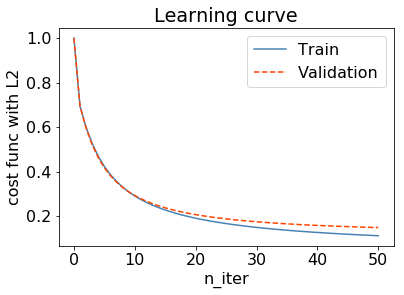

------Taken features: sepal_length(cm)[standardized], petal_length(cm)[standardized]------
------コスト関数値の推移（学習用データ）------
 [1, 0.6979605375197383, 0.56386415444074, 0.47265421089095466, 0.40846293543060747, 0.3614320363844233, 0.3256715445949838, 0.29760583679437447, 0.27498940675728756, 0.2563588171772087, 0.24072631122763233, 0.22740385455242312, 0.2158986618640279, 0.20584904952514613, 0.19698378411868636, 0.18909556447901213, 0.18202326409214614, 0.1756397554600079, 0.16984338197980794, 0.16455186856572762, 0.15969789718808108, 0.15522584083872112, 0.151089317605395, 0.14724933462243245, 0.14367286251522415, 0.14033172825164048, 0.13720174642087693, 0.13426203109845525, 0.1314944459423312, 0.12888316114416318, 0.12641429374122562, 0.12407561351840536, 0.12185630093223863, 0.11974674660601396, 0.11773838427912901, 0.11582355085755593, 0.113995368556184, 0.11224764515607275, 0.1105747891985168, 0.10897173756049494, 0.10743389334468724, 0.10595707240312442, 0.10453745712013715, 0.10317

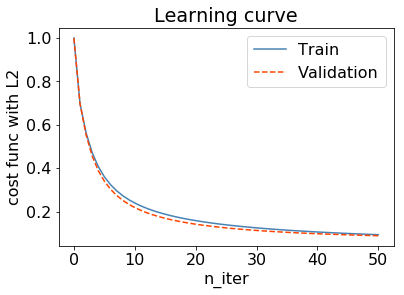

------Taken features: sepal_length(cm)[standardized], pepal_width(cm)[standardized]------
------コスト関数値の推移（学習用データ）------
 [1, 0.6979634957956408, 0.5634909368508212, 0.47150290269415185, 0.4064951129209127, 0.35873643356867774, 0.3223600946699868, 0.2937807263826676, 0.27073615166624204, 0.25174721869867406, 0.23581319233451978, 0.22223575120215716, 0.21051403556596163, 0.20028000491030484, 0.19125737873402504, 0.18323480619391952, 0.17604787520148443, 0.16956676359013384, 0.1636875820211086, 0.15832618783545083, 0.15341368727857818, 0.14889311332876048, 0.14471693631942298, 0.14084517389582088, 0.1372439385901284, 0.1338843092262306, 0.13074144492169104, 0.12779388291398538, 0.12502297715640578, 0.12241244577729289, 0.11994800350212415, 0.11761706095434789, 0.11540847702262864, 0.11331235365160931, 0.11131986478740824, 0.10942311300346608, 0.10761500870009852, 0.10588916782199177, 0.10423982485140147, 0.10266175846909771, 0.101150227772978, 0.0997009173375897, 0.09830988971041558, 0.09

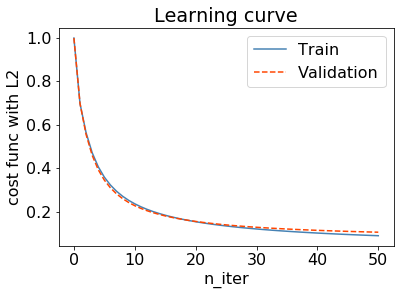

------Taken features: sepal_width(cm)[standardized], petal_length(cm)[standardized]------
------コスト関数値の推移（学習用データ）------
 [1, 0.6936195354494152, 0.5644183880520174, 0.47204372225580005, 0.40441064304247604, 0.3534287422725923, 0.31390270792080205, 0.282484237828588, 0.25696821929167224, 0.2358624779435711, 0.21812922199677576, 0.20302789971625831, 0.19001758432066398, 0.17869479786171688, 0.1687528983367938, 0.15995490753717875, 0.15211492107974353, 0.14508512611829683, 0.13874656315465483, 0.1330024382531218, 0.12777320494315259, 0.1229928951674217, 0.11860634573782018, 0.11456707617676701, 0.11083564673548996, 0.10737837477564276, 0.10416632167827014, 0.10117448615235997, 0.09838115657937087, 0.09576738703225075, 0.09331657030065472, 0.0910140876194363, 0.08884701950615503, 0.08680390563002251, 0.08487454428493409, 0.08304982405350908, 0.08132158179230956, 0.07968248225975463, 0.07812591563454799, 0.07664590989755828, 0.07523705562139447, 0.07389444116479067, 0.07261359662999947, 0.0

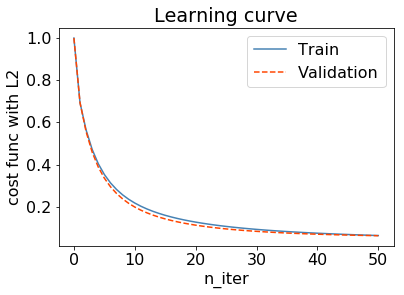

------Taken features: sepal_width(cm)[standardized], pepal_width(cm)[standardized]------
------コスト関数値の推移（学習用データ）------
 [1, 0.693622860035226, 0.5640838565229226, 0.4711337324929939, 0.40293495473186475, 0.35149595240934656, 0.3116379388798624, 0.2799979857226768, 0.2543488782638992, 0.23317756200992443, 0.21542900523586678, 0.20034918765392368, 0.1873869232337571, 0.17613101139428244, 0.16626902832961715, 0.15755967762658246, 0.14981383416581495, 0.1428812863814142, 0.13664129252923501, 0.1309957398605925, 0.1258641124518812, 0.12117973688005318, 0.11688694469132789, 0.11293890202357446, 0.10929593113061999, 0.10592419902733635, 0.10279468323472284, 0.09988234888192508, 0.09716548860159747, 0.09462518896113822, 0.0922448960890235, 0.09001005968598165, 0.08790783944206351, 0.0859268614889243, 0.08405701523558161, 0.08228928300204169, 0.08061559644774335, 0.07902871501306644, 0.07752212254137648, 0.07608993899182423, 0.07472684473803026, 0.07342801541120625, 0.07218906561555824, 0.07100

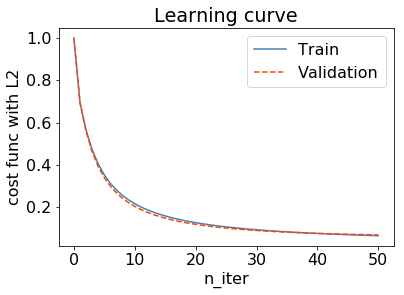

------Taken features: petal_length(cm)[standardized], pepal_width(cm)[standardized]------
------コスト関数値の推移（学習用データ）------
 [1, 0.6986898959612334, 0.5292240104729447, 0.41889171645854995, 0.34438517854914136, 0.29180687045239045, 0.25315578933687627, 0.22373221737307417, 0.2006699973382788, 0.18214948910255624, 0.16697105216542626, 0.15431661255591642, 0.14361143904012663, 0.134441075933622, 0.1264997166747749, 0.11955711955243613, 0.11343681128547556, 0.10800136519971514, 0.10314223239080211, 0.09877257437185631, 0.09482211809276252, 0.09123340094954768, 0.08795898859600601, 0.08495938494004415, 0.08220144217796665, 0.0796571371258444, 0.07730261934383109, 0.07511746333693933, 0.07308407567955463, 0.07118722095531198, 0.0694136396889709, 0.06775173813601083, 0.06619133466905344, 0.06472345108828521, 0.0633401398509764, 0.06203434021738656, 0.06079975782608628, 0.05963076336866009, 0.0585223069236926, 0.05746984519953441, 0.05646927947341554, 0.05551690243708743, 0.05460935249318343, 0.0

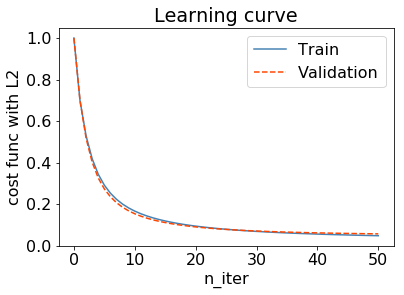

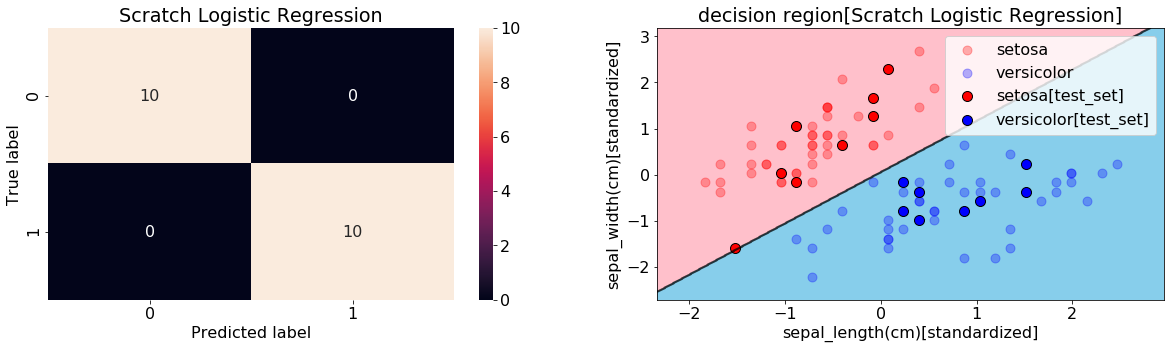

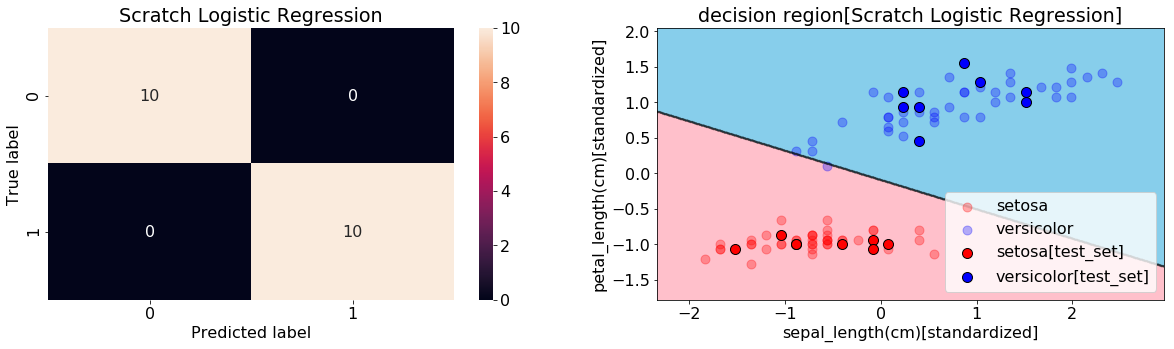

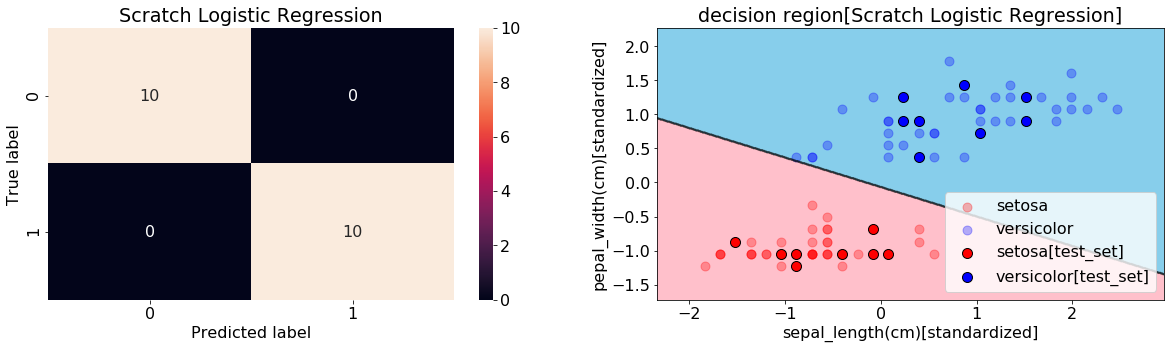

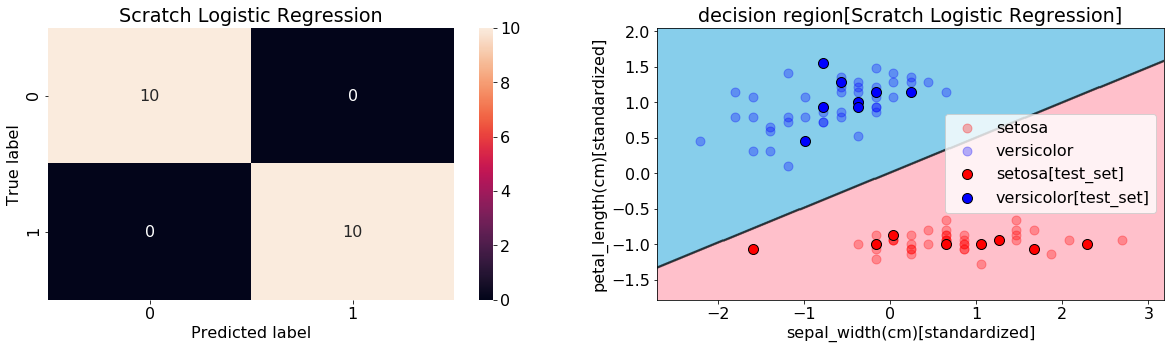

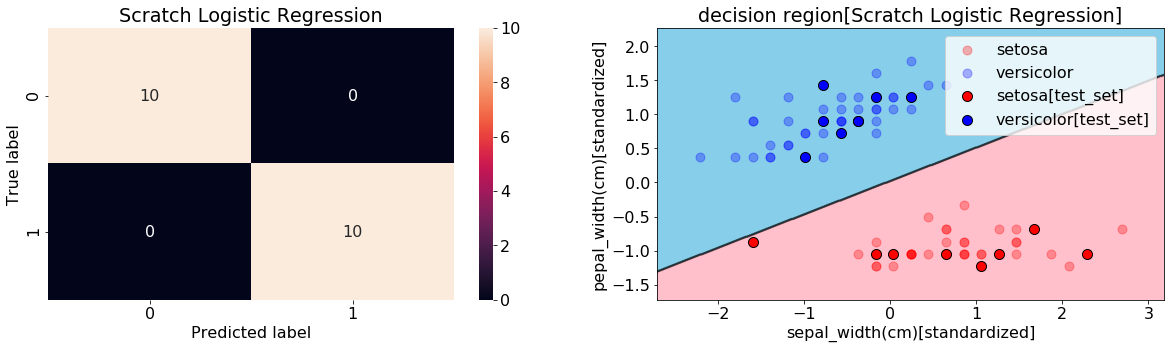

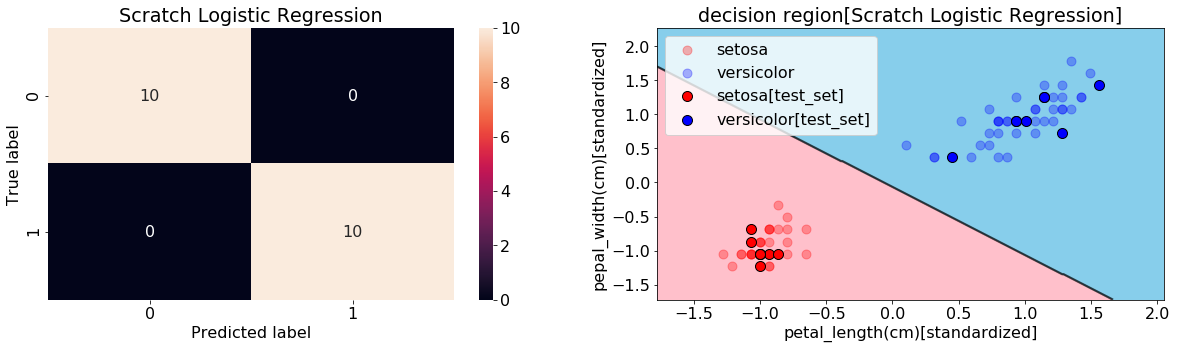

,train_accuracy,test_accuracy,test_precision,test_recall,test_f1_score
Scratch Logistic Regression,1.00,1.0,1.0,1.0,1.0
Scratch Logistic Regression,0.99,1.0,1.0,1.0,1.0
Scratch Logistic Regression,1.00,1.0,1.0,1.0,1.0
Scratch Logistic Regression,1.00,1.0,1.0,1.0,1.0
Scratch Logistic Regression,1.00,1.0,1.0,1.0,1.0
Scratch Logistic Regression,1.00,1.0,1.0,1.0,1.0


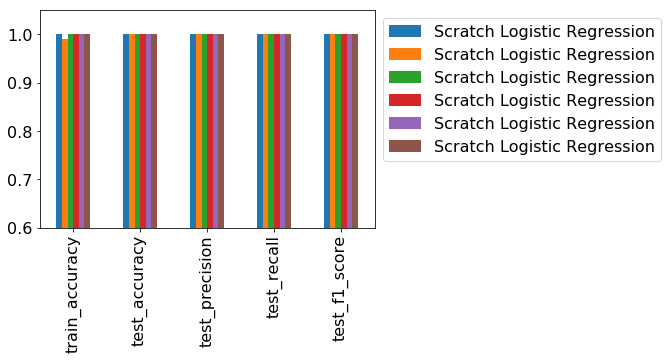

In [287]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# irisの2値分類(SetosaとVersicolor)
iris = load_iris()
X = iris.data[:100, :]
y = iris.target[:100]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=0)
feature_names=["sepal_length(cm)[standardized]", "sepal_width(cm)[standardized]", 
                   "petal_length(cm)[standardized]", "pepal_width(cm)[standardized]"]
target_names=['setosa', 'versicolor']

pipe_clf.log_reg(X_train, X_test, y_train, y_test, 
                 feature_names, target_names, lr=0.4, val_size=0.20, test_size=0.20, two_features=True)

特徴量2種類の場合は、two_features=Falseの場合でも可視化可能なので決定領域が出力され、コードの条件分岐が正常に機能していることが確認できる。

## 5. 分類と回帰
最終発表時に以下の内容についてディスカッションを行う。自分なりの意見を用意しておく。  
- 分類問題と回帰問題は本質的に何が異なっているか  

**注意点**  
答えがある問いではないので、いろいろな視点から見て理解を深めていく。